In [3]:
from torch import nn
import torch
from torch import tensor 
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm
from pathlib import Path
import os

dataset_name = 'enbackfMRI'
train_out = Path(os.getcwd()+'/data1/Suicidalideation_'+dataset_name+'_train.csv')
test_out =Path(os.getcwd()+'/data1/Suicidalideation_'+dataset_name+'_test.csv')


train_data= pd.read_csv(train_out)
test_data= pd.read_csv(test_out)
target ='Suicidalideation.x'
unused_feat = ['Set', 'subjectkey', 'abcd_site.x', 'Unnamed: 0', 'kflod',
               'src_subject_id','interview_date','gender','eventname']
n=0
start_mri = 0;
for i in test_data.columns:
    #print(i)
    if i =='tfmri_nback_all_0.back_beta_cort.destrieux_g.and.s.cingul.mid.ant.lh':
        start_mri =n
    n +=1

    
mri = list(test_data.columns[start_mri:])
print(mri)
Num_FOLDS  = 5
# the number of feature that you want to show 
Num_feat = 20

['tfmri_nback_all_0.back_beta_cort.destrieux_g.and.s.cingul.mid.ant.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.and.s.cingul.mid.post.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.cingul.post.dorsal.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.cingul.post.ventral.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.cuneus.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.front.inf.opercular.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.front.inf.orbital.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.front.inf.triangul.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.front.middle.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.front.sup.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.ins.lg.and.s.cent.ins.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.insular.short.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.occipital.middle.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.occipital.sup.lh', 'tfmri_nback_all_0.back_beta_cort.destrieux_g.oc.

In [4]:
mri


['tfmri_nback_all_0.back_beta_cort.destrieux_g.and.s.cingul.mid.ant.lh',
 'tfmri_nback_all_0.back_beta_cort.destrieux_g.and.s.cingul.mid.post.lh',
 'tfmri_nback_all_0.back_beta_cort.destrieux_g.cingul.post.dorsal.lh',
 'tfmri_nback_all_0.back_beta_cort.destrieux_g.cingul.post.ventral.lh',
 'tfmri_nback_all_0.back_beta_cort.destrieux_g.cuneus.lh',
 'tfmri_nback_all_0.back_beta_cort.destrieux_g.front.inf.opercular.lh',
 'tfmri_nback_all_0.back_beta_cort.destrieux_g.front.inf.orbital.lh',
 'tfmri_nback_all_0.back_beta_cort.destrieux_g.front.inf.triangul.lh',
 'tfmri_nback_all_0.back_beta_cort.destrieux_g.front.middle.lh',
 'tfmri_nback_all_0.back_beta_cort.destrieux_g.front.sup.lh',
 'tfmri_nback_all_0.back_beta_cort.destrieux_g.ins.lg.and.s.cent.ins.lh',
 'tfmri_nback_all_0.back_beta_cort.destrieux_g.insular.short.lh',
 'tfmri_nback_all_0.back_beta_cort.destrieux_g.occipital.middle.lh',
 'tfmri_nback_all_0.back_beta_cort.destrieux_g.occipital.sup.lh',
 'tfmri_nback_all_0.back_beta_cort.d

In [5]:
train_data_processed = train_data.fillna(0).reset_index(drop=True)
features = [ col for col in train_data_processed.columns if col not in unused_feat + [target] + mri] 

object_feat =[]

j=0
for i in test_data[features].dtypes:
    #print(j)
    if i == 'object':
        print(test_data[features].columns[j])
        object_feat.append(test_data[features].columns[j])
    j+=1
    
print(object_feat)

features = [ col for col in train_data_processed.columns if col not in unused_feat + [target] +mri +object_feat] 


[]


In [6]:
def preproecessing (train_data, test_data, NUM_FOLDS):
    test_data_processed= test_data.fillna(0).reset_index(drop=True)
    train_data_processed = train_data.fillna(0).reset_index(drop=True)
    
    test_data_processed["kfold"] = -1

    train_data_processed["kfold"] = -1

    train_data_processed = train_data_processed.sample(frac=1,random_state=2020).reset_index(drop=True)

    kf = KFold(n_splits=NUM_FOLDS)

    for fold, (trn_, val_) in enumerate(kf.split(X=train_data_processed, y=train_data_processed)):
        train_data_processed.loc[val_, 'kfold'] = fold
    print("done preprocessing")
    return train_data_processed, test_data_processed

def rocvis(true , prob , label ) :
    from sklearn.metrics import roc_curve
    if type(true[0]) == str :
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        true = le.fit_transform(true)
    else :
        pass
    fpr, tpr, thresholds = roc_curve(true, prob)
    plt.plot(fpr, tpr, marker='.', label = label  )
    
# Augmented
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm

def feature(Num_feat, clf, test_data_processed, features):
    importance =clf.feature_importances_
    #plt.plot(importance)
    #plt.show()
    labels_importance=importance.argsort()[::-1]

    importance_sort = np.sort(importance)[::-1]

    feat_name_sort=test_data_processed[features].columns[labels_importance]
    important_features = pd.DataFrame() 


    for i in range (Num_feat):
        feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['feature name', 'ratio'])
        important_features=pd.concat([important_features,feature])

    return important_features.reset_index(drop=True)

def find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test):
    # Store maximum auc
    max_auc= 0
    # Store maximum hypterparameter set
    max_hy = []
    # define hyperparameter space
    """
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    # Orginal hyperparameter space 
    """
    # define hyperparameter space (quick version)
    n_ = [4,8]
    lr_ = [2e-2,1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99]
    ss_ = [10, 20]
  
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    
    for hy in tqdm(h_space):
        clf = TabNetClassifier(n_a = hy[0],
                               n_d = hy[0],
                               optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                               scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                               scheduler_fn=torch.optim.lr_scheduler.StepLR,
                               verbose=0
                               )
        clf.fit(X_train, Y_train, X_valid, Y_valid, patience=10, batch_size=256, max_epochs=200)
        #clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200) (Recommended)
        preds_acc = clf.predict(X_test)
        preds_prob = clf.predict_proba(X_test)
        test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
        test_acc = accuracy_score(preds_acc, Y_test)
        print("--------Valid score: {} --------------------".format(-clf.best_cost))
        print("--------Test auc: {} Test acc:{}-------------".format(test_auc, test_acc) )
        if test_auc>max_auc:
            max_hy = hy
            max_auc = test_auc
    return max_hy
    
def bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, max_hy, features):
 
    hy = max_hy
    clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                               )
    clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200)
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
    test_acc = accuracy_score(preds_acc, Y_test)
    
    
    
    print("Max hy:" ,hy)
    print("--------Valid score: {} --------------------".format(-clf.best_cost))
    print("FINAL TEST SCORE(max) test auc: {} test acc: {}".format(test_auc, test_acc))
    return test_auc, clf, preds_prob
    
    
def run(train_data_processed, test_data_processed, fold, Num_feat, features):
    X_test = test_data_processed[features].values
    Y_test = test_data_processed[target].values

    df_train = train_data_processed[train_data_processed.kfold != fold]
    df_valid = train_data_processed[train_data_processed.kfold == fold]
    
    X_train = df_train[features].values
    Y_train = df_train[target].values
    
    X_valid = df_valid[features].values
    Y_valid = df_valid[target].values
    
    y_oof = np.zeros((df_valid.shape[0],len(target)))   # Out of folds validation
    
    print("---------------------------------------Training Begining for fold {}-------------------------------".format(fold+1))
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    # Start training
    max_hy = find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test)
    
    print("Found maximum hyperparmeter, now work with that")
    
    test_auc, clf, preds_prob = bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test
                                               , max_hy, features)
    
    import_feat=feature(Num_feat, clf, test_data_processed, features)
    preds_val_prob = clf.predict_proba(X_valid)

    return test_auc, Y_test, clf, preds_prob, import_feat, Y_valid, preds_val_prob



    
def hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat):
    CV_auc_all = []
    train_data_processed, test_data_processed = preproecessing (train_data, test_data, Num_FOLDS)
    import_feat_every = pd.DataFrame()
    features_all = [ col for col in train_data_processed.columns if col not in unused_feat + [target]] 
    features_mri = [ col for col in mri if col not in 'rsfmri_cor_network.gordon_subcort.aseg_visitid']  
    features_pheno = [ col for col in train_data_processed.columns if col not in unused_feat + [target] 
                +mri] 
    print("all")
    test_auc_all, Y_test_all, clf, preds_prob_all, import_feat_all, Y_valid_all, preds_val_prob_all = run(train_data_processed,
                                                                         test_data_processed,
                                                                         0, 
                                                                         Num_feat, 
                                                                         features_all
                                             )
    print("pheno")
    test_auc_pheno, Y_test_pheno, clf, preds_prob_pheno, import_feat_pheno, Y_valid_pheno, preds_val_prob_pheno = run(train_data_processed, test_data_processed, 
                                            0, Num_feat, features_pheno)
  
    print("mri")
    test_auc_mri, Y_test_mri, clf, preds_prob_mri, import_feat_mri, Y_valid_mri, preds_val_prob_mri = run(train_data_processed, test_data_processed,
                                            0, Num_feat, features_mri)
  
    
    fig , ax = plt.subplots(figsize= (20,10))
    plt.plot([0, 1], [0, 1], linestyle='--')
    rocvis(Y_test_all , preds_prob_all[:,1] , "MRI+Pheno")
    rocvis(Y_test_pheno , preds_prob_pheno[:,1] , "Pheno")
    rocvis(Y_test_mri , preds_prob_mri[:,1] , "MRI")
    #rocvis(caty_Test , catprob[:,1] , "CatBoost")
    plt.legend(fontsize = 20)
    plt.title(dataset_name, fontsize= 25)
    plt.tight_layout()
    plt.savefig(f'{dataset_name}_ROC.png')

    
    plt.show()
    return test_auc_all, test_auc_pheno, test_auc_mri, import_feat_all, import_feat_pheno, import_feat_mri, Y_test_all , preds_prob_all, Y_test_pheno , preds_prob_pheno, Y_test_mri , preds_prob_mri, Y_valid_all, preds_val_prob_all, Y_valid_pheno, preds_val_prob_pheno, Y_valid_mri, preds_val_prob_mri
    
      


done preprocessing
all
---------------------------------------Training Begining for fold 1-------------------------------


Device used : cuda
--------Valid score: 0.7678379002463054 --------------------
--------Test auc: 0.7492480175006836 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.7655480295566502 --------------------
--------Test auc: 0.7410901467505242 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.7716768011083742 --------------------
--------Test auc: 0.7410445720535958 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.7655480295566502 --------------------
--------Test auc: 0.7410901467505242 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.7504522013546797 --------------------
--------Test auc: 0.7212651535867286 Test acc:0.5791245791245792-------------
Device used : cuda
--------Valid score: 0.7269762161330049 --------------------
--------Test auc: 0.691094704220217 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.74802763238

Device used : cuda
--------Valid score: 0.771147629310345 --------------------
--------Test auc: 0.7443715249293592 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.7711476293103448 --------------------
--------Test auc: 0.7505696837116034 Test acc:0.5387205387205387-------------
Device used : cuda
--------Valid score: 0.7632100523399015 --------------------
--------Test auc: 0.7487466958344727 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.7608913177339903 --------------------
--------Test auc: 0.7441892261416462 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.7477101293103448 --------------------
--------Test auc: 0.7047215386017683 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.7442175954433496 --------------------
--------Test auc: 0.7034910217847051 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.76593288177

Device used : cuda
--------Valid score: 0.48767510775862066 --------------------
--------Test auc: 0.46417828821438345 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.48767510775862066 --------------------
--------Test auc: 0.46417828821438345 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.48767510775862066 --------------------
--------Test auc: 0.46417828821438345 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.48767510775862066 --------------------
--------Test auc: 0.46417828821438345 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.5165582666256159 --------------------
--------Test auc: 0.46796098805942943 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.5165582666256159 --------------------
--------Test auc: 0.46796098805942943 Test acc:0.5353535353535354-------------
Device used : cuda
--------Valid score: 0.

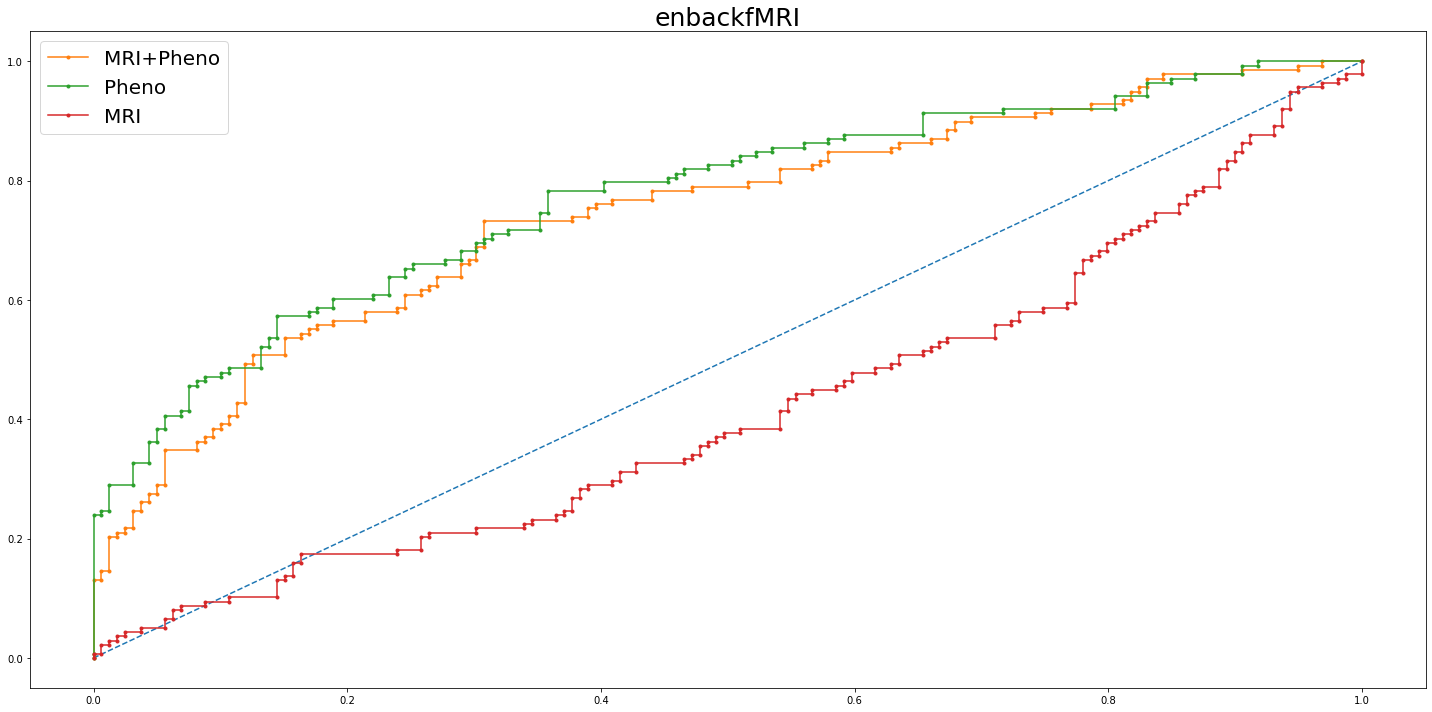

In [7]:
test_auc_all, test_auc_pheno, test_auc_mri, import_feat_all, import_feat_pheno, import_feat_mri, Y_test_all , preds_prob_all, Y_test_pheno , preds_prob_pheno, Y_test_mri , preds_prob_mri, Y_valid_all, preds_val_prob_all, Y_valid_pheno, preds_val_prob_pheno, Y_valid_mri, preds_val_prob_mri= hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat)
    

In [8]:
valid_auc_all = roc_auc_score (Y_valid_all, preds_val_prob_all[:,1])
valid_auc_pheno = roc_auc_score (Y_valid_pheno, preds_val_prob_pheno[:,1])
valid_auc_mri = roc_auc_score (Y_valid_mri, preds_val_prob_mri[:,1])

In [9]:
print(dataset_name)
print("")
print("Test AUC")
print(f"Pheno+MRI:{round((test_auc_all)*100,2)}%")
print( f"Pheno:{round((test_auc_pheno),4)*100}%")
print(f"MRI:{round((test_auc_mri)*100,2)}%")
print("")
    
print("Valid AUC")

print( f"Pheno+MRI:{round(valid_auc_all,4)*100}%")
print( f"Pheno:{round(valid_auc_pheno*100,2)}%")
print( f"MRI:{round(valid_auc_mri,4)*100}%")

enbackfMRI

Test AUC
Pheno+MRI:74.6%
Pheno:77.27000000000001%
MRI:41.6%

Valid AUC
Pheno+MRI:76.21%
Pheno:77.59%
MRI:57.84%


In [10]:
import_feat_every=pd.concat([import_feat_all,import_feat_pheno, import_feat_mri])

import_feat_every.to_csv(f"{dataset_name}_features.csv")

import_feat_every 


,feature name,ratio
0,PPSP_frequency,0.142705
1,Depress.CBCL,0.097526
2,PPSP_distress,0.082541
3,TotProb.CBCL,0.070671
4,upps_negative_urgency,0.033359
5,tfmri_nback_all_posface.vs.neutface_beta_cort....,0.030912
6,tfmri_nback_all_emotion_beta_cort.destrieux_g....,0.029635
7,tfmri_nback_all_posface.vs.neutface_beta_cort....,0.026623
8,Thought.CBCL,0.025747
9,tfmri_nback_all_negface.vs.neutface_beta_cort....,0.025571
